# Reset Env

In [1]:
!export PATH=$PATH:.

In [2]:
import shutil
import os
import json


# Define the paths
folder_path = "/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/Intelligent-Liquidity-Provisioning-Framework-V1/v3_core/build/deployments"
json_file1_path = "/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/Intelligent-Liquidity-Provisioning-Framework-V1/model_storage/token_pool_addresses.json"
json_file2_path = "/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/Intelligent-Liquidity-Provisioning-Framework-V1/model_storage/liq_positions.json"

# 1. Delete the folder and its contents
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

# 2. Delete contents of the first JSON file
with open(json_file1_path, 'w') as file:
    file.write("{}")

# 3. Delete contents of the second JSON file and add {}
with open(json_file2_path, 'w') as file:
    file.write("{}")

"Simulation reset operations completed successfully."

'Simulation reset operations completed successfully.'

# Setup

In [3]:
!export PATH=$PATH:.
import os
os.chdir('/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/Intelligent-Liquidity-Provisioning-Framework-V1')
os.environ["PATH"] += ":."

In [ ]:
from netlists.uniswapV3.netlist import SimStrategy,SimState,netlist_createLogData
from engine.SimEngine import SimEngine
from util.globaltokens import weth_usdc_pool,eth_dai_pool,btc_usdt_pool
import brownie
from util.constants import GOD_ACCOUNT,RL_AGENT_ACCOUNT
from util.base18 import toBase18, fromBase18,fromBase128,price_to_valid_tick
from model_scripts.plot import train_rewards_plot,eval_rewards_plot,train_raw_actions_plot,train_scaled_actions_plot,train_combined_metrics_plot,train_separate_episode_action_plot

In [5]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

import gymnasium as gym

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Stablebaseline3 imports
#import stable_baselines3
#from stable_baselines3 import PPO
#from stable_baselines3.common.vec_env import DummyVecEnv
#from stable_baselines3.common.vec_env import VecFrameStack
#from stable_baselines3.common.evaluation import evaluate_policy

2023-11-21 10:50:01.314496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 10:50:01.314571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 10:50:01.348118: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 10:50:05.993217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 10:50:55.293725: W tensorflow/compiler/

## Run ABM

In [6]:
from netlists.uniswapV3.netlist import SimStrategy,SimState,netlist_createLogData
from util.globaltokens import weth_usdc_pool,eth_dai_pool,btc_usdt_pool,fundToken1FromAbove,fundToken0FromAbove

sim_strategy = SimStrategy()
sim_state = SimState(ss=sim_strategy,pool=weth_usdc_pool)

output_dir = "model_outdir_csv"
netlist_log_func = netlist_createLogData

from engine.SimEngine import SimEngine
engine = SimEngine(sim_state, output_dir, netlist_log_func)

retail_lp_agent=sim_state.agents['retail_lp']._wallet.address
print(f'retail_lp_agent: {retail_lp_agent}')

noise_trader=sim_state.agents['noise_trader']._wallet.address
print(f'noise_trader_agent: {noise_trader}')

engine.reset()
engine.run()

mnemonic: 'midnight spawn crawl hen ripple pupil mouse keen lift hockey illegal end'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x3A818c16f1d8020648AbC11C0fcBa91A702DAf86'), ('value', 1000000000000000019884624838656)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x3A818c16f1d8020648AbC11C0fcBa91A702DAf86'), ('value', 110000000000000000498458871988224)])]}
mnemonic: 'purity swing fruit record ketchup walnut island velvet slam network hamster soda'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x4eFC06Bd93dF31E963BA1221cc9F405ddeF7D9d7'), ('value', 4999999999999999727876154935214080)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x4eFC06Bd93dF31E963BA1221cc9F405ddeF7D9d7'), ('value', 550000

# Agent env

In [149]:
class DiscreteSimpleEnv(gym.Env):
    def __init__(self,agent_budget_usd):
        super(DiscreteSimpleEnv, self).__init__()

        self.pool=None
        self.global_state=None
        self.curr_price=None
        self.action_lower_bound=None
        self.action_upper_bound=None
        self.state=None
        self.engine=None
        
        self.action_space = gym.spaces.Dict({
            'price_relative_lower': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'price_relative_upper': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
        })
        
        self.reward=0
        self.cumulative_reward = 0
        self.done=False
        self.episode=0
        self.step_count=0

        self.observation_space = gym.spaces.Dict({
            'scaled_curr_price': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_liquidity': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_feeGrowthGlobal0x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_feeGrowthGlobal1x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),   
        })
        self.agent_budget_usd = agent_budget_usd
        self.initial_budget_usd = agent_budget_usd

        # Initialize rewrad normalization running statistics
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0

        self.exploration_std_dev = 0.01
        self.penalty=0

        # Initialize running statistics for state normalization
        self.curr_price_mean = 0
        self.curr_price_std = 1
        self.liquidity_mean = 0
        self.liquidity_std = 1
        self.fee_growth_diff_0 = 0
        self.fee_growth_diff_1 = 0
        self.fee_growth_0_mean = 0
        self.fee_growth_1_mean = 0
        self.fee_growth_0_std = 1
        self.fee_growth_1_std = 1
        self.previous_fee_growth_0 = 0
        self.previous_fee_growth_1 = 0
        self.alpha = 0.9
        
    def reset(self):
        self.pool=random.choice([weth_usdc_pool,eth_dai_pool,btc_usdt_pool])
        
        print(f'Pool selcted for this episode: {self.pool.pool_id}')
        sim_strategy = SimStrategy()
        sim_state = SimState(ss=sim_strategy,pool=self.pool)

        output_dir = "model_outdir_csv"
        netlist_log_func = netlist_createLogData

        #from engine.SimEngine import SimEngine
        self.engine = SimEngine(sim_state, output_dir, netlist_log_func)

        self.global_state=self.pool.get_global_state()
        self.curr_price=self.global_state['curr_price']
        self.action_lower_bound=self.curr_price*0.1
        self.action_upper_bound=self.curr_price*2
        self.state = self.get_obs_space()
        
        self.done=False
        self.reward=0
        self.cumulative_reward = 0
        self.episode+=1
        self.step_count=0
        # Used for evaluation only
        self.cumulative_reward_rl_agent = 0
        self.cumulative_reward_baseline_agent = 0

        self.agent_budget_usd = self.initial_budget_usd
         
        # reset running statistics for reward normalization
        '''
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0
        '''
        # reset running statistics for state normalization
        '''
        self.curr_price_mean = 0
        self.curr_price_std = 1
        self.liquidity_mean = 0
        self.liquidity_std = 1
        self.fee_growth_diff_0 = 0
        self.fee_growth_diff_1 = 0
        self.fee_growth_0_mean = 0
        self.fee_growth_1_mean = 0
        self.fee_growth_0_std = 1
        self.fee_growth_1_std = 1
        self.previous_fee_growth_0 = 0
        self.previous_fee_growth_1 = 0
        '''  
        return self.state

    def step(self, raw_action):
              
        # Execute agent's action using pool's interface of add/remove liquidity
        mint_tx_receipt,action=self._take_action(raw_action)
        
        # run uniswap abm env of n_steps
        print()
        print('Environment Step')
        self.engine.reset()
        self.engine.run()
        print()
        
        self.state=self.get_obs_space()

        scaled_reward,raw_reward,fee_income,impermanent_loss = self._calculate_reward(action,mint_tx_receipt)
        self.reward=scaled_reward
        self.cumulative_reward += self.reward

        self.step_count+=1
        
        print(f"episode: {self.episode}, step_count: {self.step_count}, scaled_reward: {self.reward}, raw_reward: {raw_reward} cumulative_reward: {self.cumulative_reward}")
        print(f"raw_pool_state: {self.pool.get_global_state()}")
        print(f"sclaed_pool_state: {self.state}")
        print()

        train_data_log.append((self.episode, self.step_count, action, self.pool.get_global_state(), raw_action, self.state, raw_reward, self.reward, self.cumulative_reward, fee_income, impermanent_loss))

        self.done = self._is_done()
        return self.state, self.reward, self.done, {}

    def get_obs_space(self):
        self.global_state = self.pool.get_global_state()

        # Scaling for curr_price and liquidity
        curr_price = float(self.global_state['curr_price'])
        liquidity = float(self.global_state['liquidity_raw'])
        fee_growth_0 = float(self.global_state['feeGrowthGlobal0X128'])
        fee_growth_1 = float(self.global_state['feeGrowthGlobal1X128'])

        self.curr_price_mean = self.alpha * curr_price + (1 - self.alpha) * self.curr_price_mean
        self.curr_price_std = np.sqrt(self.alpha * (curr_price - self.curr_price_mean)**2 + (1 - self.alpha) * self.curr_price_std**2)

        self.liquidity_mean = self.alpha * liquidity + (1 - self.alpha) * self.liquidity_mean
        self.liquidity_std = np.sqrt(self.alpha * (liquidity - self.liquidity_mean)**2 + (1 - self.alpha) * self.liquidity_std**2)

        obs = {'scaled_curr_price': (curr_price - self.curr_price_mean) / (self.curr_price_std + 1e-10),'scaled_liquidity': (liquidity - self.liquidity_mean) / (self.liquidity_std + 1e-10),}

        # Scaling for fee growth differences 
        self.fee_growth_diff_0 = fee_growth_0 - self.previous_fee_growth_0
        self.fee_growth_diff_1 = fee_growth_1 - self.previous_fee_growth_1

        self.fee_growth_0_mean = self.alpha * self.fee_growth_diff_0 + (1 - self.alpha) * self.fee_growth_0_mean
        self.fee_growth_0_std = np.sqrt(self.alpha * (self.fee_growth_diff_0 - self.fee_growth_0_mean)**2 + (1 - self.alpha) * self.fee_growth_0_std**2)

        self.fee_growth_1_mean = self.alpha * self.fee_growth_diff_1 + (1 - self.alpha) * self.fee_growth_1_mean
        self.fee_growth_1_std = np.sqrt(self.alpha * (self.fee_growth_diff_1 - self.fee_growth_1_mean)**2 + (1 - self.alpha) * self.fee_growth_1_std**2)

        obs['scaled_feeGrowthGlobal0x128'] = (self.fee_growth_diff_0 - self.fee_growth_0_mean) / (self.fee_growth_0_std + 1e-10)
        obs['scaled_feeGrowthGlobal1x128'] = (self.fee_growth_diff_1 - self.fee_growth_1_mean) / (self.fee_growth_1_std + 1e-10)

        self.previous_fee_growth_0 = fee_growth_0
        self.previous_fee_growth_1 = fee_growth_1

        #obs = {'scaled_curr_price': curr_price,'scaled_liquidity': liquidity}
        #obs['scaled_feeGrowthGlobal0x128'] = fee_growth_0
        #obs['scaled_feeGrowthGlobal1x128'] = fee_growth_1

        return obs

    def _take_action(self, action):
        self.penalty=0

        raw_a, raw_b = action[0, 0].numpy(), action[0, 1].numpy()

        # Add exploration noise
        
        a_0 = raw_a + np.random.normal(0, self.exploration_std_dev)
        a_1 = raw_b + np.random.normal(0, self.exploration_std_dev)

        a_0 = np.clip(a_0, 0, 1)
        a_1 = np.clip(a_1, 0, 1)
 
        # Only enabling agent to provide liquiidty around bounds midpoint
        price_lower = self.action_lower_bound + a_0 * (self.action_upper_bound - self.action_lower_bound)/2
        price_upper = (self.action_upper_bound - self.action_lower_bound)/2 + a_1 * (self.action_upper_bound - self.action_lower_bound)/2
        
        # Enabling agent to place range orders too (Only feasible when using multiple positions)
        #price_lower = self.action_lower_bound + a_0 * (self.action_upper_bound - self.action_lower_bound)
        #price_upper = self.action_lower_bound + a_1 * (self.action_upper_bound - self.action_lower_bound)
        
        # Ensure price_lower is less than price_upper - Add penalty
        if price_lower>price_upper:
            price_lower = min(price_lower, price_upper)
            price_upper = max(price_lower, price_upper)
            self.penalty=-10

        # ensure actions are not too close - Add penalty
        min_diff_percentage = 0.05  # 5% difference
        price_diff = price_upper - price_lower
        
        if price_diff < min_diff_percentage * price_lower:
            self.penalty+=-10
            price_upper = price_lower + min_diff_percentage * price_lower

        action_dict = {
            'price_lower': price_lower,
            'price_upper': price_upper
        }
        
        print('RL Agent Action')
        print(f"raw_action: {action}, scaled_action: {action_dict}")

        tick_lower=price_to_valid_tick(action_dict['price_lower'])
        tick_upper=price_to_valid_tick(action_dict['price_upper'])
        amount=self.agent_budget_usd

        mint_tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        return mint_tx_receipt,action_dict
        
    def _calculate_reward(self,action,mint_tx_receipt):
       
        tick_lower=price_to_valid_tick(action['price_lower'],60)
        tick_upper=price_to_valid_tick(action['price_upper'],60)
        liquidity=mint_tx_receipt.events['Mint']['amount']

        # Collecting fee earned by position
        print('Collect fee')
        collect_tx_receipt,fee_income = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper,poke=True)
    
        print("Burn Position and Collect Tokens")
        # Remove position and collect tokens
        burn_tx_receipt=self.pool.remove_liquidity_with_liquidty(GOD_ACCOUNT, tick_lower, tick_upper, liquidity)
        collect_tx_receipt,curr_budget_usd = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper,poke=False)

        # Can use online scaling approach as used for reward for this
        rel_portofolio_value = 1 - curr_budget_usd/self.agent_budget_usd
        
        # Instead of using full budget for next step use previous step's reomved liquidity amount as budget in next step
        #self.agent_budget_usd = curr_budget_usd
        
        # Calculate IL
        amount0_initial = mint_tx_receipt.events['Mint']['amount0']
        amount1_initial = mint_tx_receipt.events['Mint']['amount1']
        
        amount0_final = burn_tx_receipt.events['Burn']['amount0']
        amount1_final = burn_tx_receipt.events['Burn']['amount1']
        self.global_state = self.pool.get_global_state()
        pool_price = float(self.global_state['curr_price'])

        value_initial = (amount0_initial * pool_price + amount1_initial) / 1e18
        value_final = (amount0_final * pool_price + amount1_final) / 1e18

        impermanent_loss = value_initial - value_final
        
        #gas_cost = self.pool.estimate_gas_cost(action)
        
        print(f'fee_earned:{fee_income}, impermannet_loss: {impermanent_loss}, penalty: {self.penalty}, initial_agent_portofolio_value: {value_initial}, final_agent_portofolio_value: {value_final}')
        print()
        raw_reward = fee_income - impermanent_loss + self.penalty #- rel_portofolio_value # - gas_cost 

        self.reward_count += 1
        new_mean = self.reward_mean + (raw_reward - self.reward_mean) / self.reward_count
        new_std = ((self.reward_std ** 2 + (raw_reward - self.reward_mean) * (raw_reward - new_mean)) / self.reward_count) ** 0.5

        self.reward_mean = new_mean
        self.reward_std = new_std

        #scaled_reward = (raw_reward - self.reward_mean) / (self.reward_std + 1e-10)

        scaled_reward = raw_reward*100

        #Reset penlaty to zero for next step
        self.penalty=0
    
        return scaled_reward,raw_reward,fee_income, impermanent_loss

    def _is_done(self):
        
        max_reward_threshold = 10000
        min_reward_threshold= -10000
        max_budget_threshold = 1.5*self.initial_budget_usd
        min_budget_threshold = 0.5*self.initial_budget_usd

        if self.cumulative_reward >= max_reward_threshold or self.cumulative_reward<=min_reward_threshold or self.agent_budget_usd>max_budget_threshold or self.agent_budget_usd<min_budget_threshold:
            return True
        else:
            return False

# RL Agents

## DDPG Agent

### Model

In [150]:
class ReplayBuffer:
    def __init__(self, max_size, input_dims, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, input_dims))
        self.new_state_memory = np.zeros((self.mem_size, input_dims))
           
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):

        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1
        #print(f"action_memory:{self.action_memory}")


    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones
    
    def clear(self):
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *self.state_memory.shape[1:]))
        self.new_state_memory = np.zeros((self.mem_size, *self.new_state_memory.shape[1:]))
        self.action_memory = np.zeros((self.mem_size, *self.action_memory.shape[1:]))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        
class Actor(tf.keras.Model):
    def __init__(self, n_actions):
        super(Actor, self).__init__()

        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='sigmoid')  # Two output units for 'price_lower' and 'price_upper'

    def call(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        
        # Use the modified output layer
        actions = self.output_layer(x)
        
        return actions
        
class Critic(tf.keras.Model):
    def __init__(self, n_actions):
        super(Critic, self).__init__()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.q = tf.keras.layers.Dense(1, activation=None)

    def call(self, state, action):
        x = tf.concat([state, action], axis=1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        q = self.q(x)
        return q
    
class DDPG:
    def __init__(self, alpha=0.001, beta=0.002, input_dims=[8], tau=0.005, env=None,
                 gamma=0.99, n_actions=2, max_size=1000000, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = Actor(n_actions=n_actions)
        self.critic = Critic(n_actions=n_actions)

        self.target_actor = Actor(n_actions=n_actions)
        self.target_critic = Critic(n_actions=n_actions)

        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

        self.env = env

        # For tensorboard logging
        self.log_dir = '/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/tensorboard_logs'
        self.train_summary_writer = tf.summary.create_file_writer(self.log_dir)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state, done):

        flat_state = self.flatten_state(state)
        flat_action = self.flatten_action(action)
        flat_new_state = self.flatten_state(new_state)
        self.memory.store_transition(flat_state, flat_action, reward, flat_new_state, done)
        

    def flatten_state(self,state_dict):
        scaled_curr_price = float(state_dict['scaled_curr_price'])
        scaled_liquidity = float(state_dict['scaled_liquidity'])
        scaled_fee_growth_0 = float(state_dict['scaled_feeGrowthGlobal0x128'])
        scaled_fee_growth_1 = float(state_dict['scaled_feeGrowthGlobal1x128'])
        
        return np.array([scaled_curr_price, scaled_liquidity, scaled_fee_growth_0, scaled_fee_growth_1])

    def unflatten_state(self,state_array):
        return {
            'scaled_curr_price': state_array[0],
            'scaled_liquidity': state_array[1],
            'scaled_feeGrowthGlobal0x128': state_array[2],
            'scaled_feeGrowthGlobal1x128': state_array[3]
        }

    def flatten_action(self,action):
        return tf.reshape(action, [-1])

    def unflatten_action(self,action):
        return tf.reshape(action, [1, -1])
    
    def choose_action(self, state):
        state_dict = state
        state_dict_float = {
            key: float(value) for key, value in state_dict.items()
        }

        state_array = np.array(list(state_dict_float.values()), dtype=np.float32)
        state_array = state_array.reshape(1, -1)
        state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)

        raw_actions_tensor = self.actor(state_tensor)
        
        return raw_actions_tensor

        
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)
        
        #print(f"{state},{action},{reward},{new_state}")
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)


        with tf.GradientTape() as tape:
            target_actions = self.target_actor(states_)
            critic_value_ = tf.squeeze(self.target_critic(
                                states_, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = tf.keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss, 
                                            self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss, 
                                    self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))
        
        print(f"Actor_Loss: {actor_loss.numpy()}, Critic_Loss: {critic_loss.numpy()}")
       
        with self.train_summary_writer.as_default():
            tf.summary.scalar('critic_loss', critic_loss.numpy(), step=self.memory.mem_cntr)
            tf.summary.scalar('actor_loss', actor_loss.numpy(), step=self.memory.mem_cntr)


        self.update_network_parameters()

### Training

In [151]:
train_data_log=[]
env=DiscreteSimpleEnv(agent_budget_usd=10000)

n_actions = sum(action_space.shape[0] for action_space in env.action_space.values())

input_dims = sum(np.prod(env.observation_space.spaces[key].shape) for key in env.observation_space.spaces.keys())

agent = DDPG(alpha=0.001, beta=0.001, input_dims=input_dims, tau=0.1, env=env,
             n_actions=n_actions, batch_size=10)

In [ ]:
n_episodes = 2
max_steps = 50

for i in range(n_episodes):
    state = env.reset()
    episode_reward = 0
    
    for _ in range(max_steps):
        action = agent.choose_action(state)

        next_state, reward, done, _ = env.step(action)
        
        agent.remember(state, action, reward, next_state, done)
        agent.learn()

        state = next_state
        episode_reward += reward
        
        if done:
            break

    print(f"Episode {i+1}: Reward = {episode_reward}")
    agent.memory.clear()
# agent.save_model()

## PPO Agent (Stochastic Policy)

4. implement batch learning
5. advantage and ppo loss calculation


In [159]:
class RolloutBuffer:
    def __init__(self, buffer_size, observation_dims, n_actions):
        self.states = np.zeros((buffer_size, observation_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, n_actions), dtype=np.float32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.dones = np.zeros(buffer_size, dtype=bool)
        self.log_probs = np.zeros((buffer_size, n_actions), dtype=np.float32)
        self.values = np.zeros(buffer_size, dtype=np.float32)
        self.next_values = np.zeros(buffer_size, dtype=np.float32)
        self.ptr, self.max_size = 0, buffer_size
        self.buffer_size=buffer_size
        self.observation_dims=observation_dims
        self.n_actions=n_actions

        self.reset()

    def store_transition(self, state, action, reward, done, log_prob, value, next_value):
        index = self.ptr % self.max_size
        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.dones[index] = done
        self.log_probs[index] = log_prob
        self.values[index] = value
        self.next_values[index] = next_value
        self.ptr += 1

    def sample(self):
        self.ptr = 0
        return (self.states, self.actions, self.rewards, self.dones, 
                self.log_probs, self.values, self.next_values)
    def reset(self):
        self.states = np.zeros((self.buffer_size, self.observation_dims), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, self.n_actions), dtype=np.float32)
        self.rewards = np.zeros(self.buffer_size, dtype=np.float32)
        self.dones = np.zeros(self.buffer_size, dtype=bool)
        self.log_probs = np.zeros((self.buffer_size, self.n_actions), dtype=np.float32)
        self.values = np.zeros(self.buffer_size, dtype=np.float32)
        self.next_values = np.zeros(self.buffer_size, dtype=np.float32)
        self.ptr = 0

    def is_full(self):
        return self.ptr >= self.buffer_size
    
class Actor(tf.keras.Model):
    def __init__(self, n_actions):
        super(Actor, self).__init__()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = tf.keras.layers.BatchNormalization()
        # Output the mean of the actions
        self.mu = tf.keras.layers.Dense(n_actions, activation='sigmoid')
        # Output the standard deviation of the actions (log std for numerical stability)
        self.sigma = tf.keras.layers.Dense(n_actions, activation='sigmoid')

    def call(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma
    
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.v = tf.keras.layers.Dense(1, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        v = self.v(x)
        return v

class PPO:
    def __init__(self, env, n_actions,observation_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95, policy_clip=0.2, buffer_size=64, max_grad_norm=0.5, n_epochs=1):
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.policy_clip = policy_clip
        self.buffer_size=buffer_size
        self.optimizer=tf.keras.optimizers.Adam(learning_rate=alpha)
        self.observation_dims=observation_dims
        self.max_grad_norm = max_grad_norm
        self.n_epochs=n_epochs
        
        self.actor = Actor(n_actions)
        self.critic = Critic()
        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))

        self.rollout_buffer = RolloutBuffer(self.buffer_size, observation_dims, n_actions)

        self.env=env

    def choose_action(self, state):

        state_dict = state
        state_dict_float = {
            key: float(value) for key, value in state_dict.items()
        }

        state_array = np.array(list(state_dict_float.values()), dtype=np.float32)
        state_array = state_array.reshape(1, -1)
        state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)

        mu, sigma = self.actor(state_tensor)
        action_prob = tfp.distributions.Normal(mu, sigma)
        action = action_prob.sample()
        
        #Action clipping
        #action = tf.clip_by_value(action, 0, 1)
        log_prob = action_prob.log_prob(action)
        
        return action,log_prob

    def remember(self, state, action, reward, next_state, done, log_prob):
        
        flat_state = self.flatten_state(state)
        flat_action = self.flatten_action(action)
        flat_next_state = self.flatten_state(next_state)
        value = self.critic(tf.convert_to_tensor([flat_state], dtype=tf.float32))
        next_value = self.critic(tf.convert_to_tensor([flat_next_state], dtype=tf.float32))
        self.rollout_buffer.store_transition(flat_state, flat_action, reward, done, log_prob, value, next_value)
    
    def learn(self):
        states, actions, rewards, dones, old_log_probs, values, next_values = self.rollout_buffer.sample()
        returns, advantages = self.compute_gae(rewards, values, next_values, dones, self.gamma, self.gae_lambda)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        old_log_probs = tf.convert_to_tensor(old_log_probs, dtype=tf.float32)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)
        # Update policy and value networks for a number of epochs
        for _ in range(self.n_epochs):
            with tf.GradientTape() as tape:
                total_loss = self.ppo_loss(states, actions, old_log_probs, advantages, returns, self.policy_clip)
            gradients = tape.gradient(total_loss, self.actor.trainable_variables + self.critic.trainable_variables)
            # Gradient clipping
            gradients, _ = tf.clip_by_global_norm(gradients, self.max_grad_norm)
            self.optimizer.apply_gradients(zip(gradients, self.actor.trainable_variables + self.critic.trainable_variables))
            
        self.rollout_buffer.reset()
       
    def compute_gae(self, rewards, values, next_values, dones, gamma=0.99, lam=0.95):
        gae = 0
        returns = np.zeros_like(rewards)
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + gamma * next_values[t] * (1 - dones[t]) - values[t]
            gae = delta + gamma * lam * (1 - dones[t]) * gae
            returns[t] = gae + values[t]
        advantages = returns - values
        return returns, (advantages - advantages.mean()) / (advantages.std() + 1e-10)

    def ppo_loss(self, states, actions, old_log_probs, advantages, returns, clip_param=0.2):
        mu, sigma = self.actor(states)
        values = tf.squeeze(self.critic(states))

        # Calculate new log probabilities using the updated policy
        new_policy = tfp.distributions.Normal(mu, sigma)
        new_log_probs = new_policy.log_prob(actions)
        print(f"old_log_probs:{old_log_probs}, new_log_probs:{new_log_probs}")

        # Policy loss
        ratios = tf.exp(new_log_probs - old_log_probs)
        print(f"ratios:{ratios}")
        ratios = tf.reduce_mean(ratios, axis=1)
        print(f"ratios:{ratios}")
        surr1 = ratios * advantages
        surr2 = tf.clip_by_value(ratios, 1 - clip_param, 1 + clip_param) * advantages
        print(f"surr1:{surr1}, surr2:{surr2}")
        policy_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
        # Value loss
        value_loss = tf.reduce_mean(tf.square(returns - values))
        # Total loss
        total_loss = policy_loss + 0.5 * value_loss
        print(f"total_loss:{total_loss}, policy_loss:{policy_loss}, value_loss:{value_loss}, advantages:{advantages}, returns:{returns}")
        return total_loss
          
    def flatten_state(self,state_dict):
        scaled_curr_price = float(state_dict['scaled_curr_price'])
        scaled_liquidity = float(state_dict['scaled_liquidity'])
        scaled_fee_growth_0 = float(state_dict['scaled_feeGrowthGlobal0x128'])
        scaled_fee_growth_1 = float(state_dict['scaled_feeGrowthGlobal1x128'])
        
        return np.array([scaled_curr_price, scaled_liquidity, scaled_fee_growth_0, scaled_fee_growth_1])

    def unflatten_state(self,state_array):
        return {
            'scaled_curr_price': state_array[0],
            'scaled_liquidity': state_array[1],
            'scaled_feeGrowthGlobal0x128': state_array[2],
            'scaled_feeGrowthGlobal1x128': state_array[3]
        }

    def flatten_action(self,action):
        return tf.reshape(action, [-1])

    def unflatten_action(self,action):
        return tf.reshape(action, [1, -1])

    def map_indices_to_action_values(self, action_indices):
        action_dict = {
            'price_relative_lower': action_indices[0],
            'price_relative_upper': action_indices[1]
        }
        return action_dict

### Training

In [160]:
train_data_log=[]
env=DiscreteSimpleEnv(agent_budget_usd=10000)
n_actions = sum(action_space.shape[0] for action_space in env.action_space.values())
input_dims = sum(np.prod(env.observation_space.spaces[key].shape) for key in env.observation_space.spaces.keys())
observation_dims = input_dims 
agent = PPO(env, n_actions, observation_dims,buffer_size=20,n_epochs=10)

In [161]:
n_episodes = 2
max_steps=60

for i in range(n_episodes):
    state = env.reset()
    episode_reward = 0
    
    for _ in range(max_steps):
        action,log_prob = agent.choose_action(state)
       

        next_state, reward, done, _ = env.step(action)

        agent.remember(state, action, reward, next_state, done,log_prob)

        state = next_state
        episode_reward += reward

        if agent.rollout_buffer.is_full():
            agent.learn()
        if done:
            break

    print(f"Episode {i+1}: Reward = {episode_reward}")

Pool selcted for this episode: BTC_USDT_3000
mnemonic: 'theme animal pony autumn elbow follow scene hair pyramid receive bag pause'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x203C33DAA4a01172FcB6B2de4E88CF3D271e71A7'), ('value', 1000000000000000019884624838656)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x203C33DAA4a01172FcB6B2de4E88CF3D271e71A7'), ('value', 110000000000000000498458871988224)])]}
mnemonic: 'cost cup start paddle output stock return napkin color brown truth increase'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x9af4c28ED303D6A80c7bD19Bb770EC0c8C83769e'), ('value', 4999999999999999727876154935214080)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x9af4c28ED303D6A80c

## Training Visulizations

In [162]:
df_data = []

for entry in train_data_log:
    episode, step_count, scaled_action, raw_state, tensor_data, scaled_state, raw_reward, scaled_reward, cumulative_reward, fee_earned, impermanent_loss = entry
    
    # Extract raw_action values from tensor_data
    raw_action_0 = float(tensor_data[0][0].numpy())
    raw_action_1 = float(tensor_data[0][1].numpy())

    scaled_action_0 = scaled_action['price_lower']
    scaled_action_1 = scaled_action['price_upper']
    
    # Combine all data into a single dictionary
    data = {
        'episode': episode,
        'step_count': step_count,
        'scaled_action_0':scaled_action_0,
        'scaled_action_1':scaled_action_1,
        'raw_reward': raw_reward,
        'scaled_reward': scaled_reward,
        'fee_earned': fee_earned,
        'impermanent_loss': impermanent_loss,
        'cumulative_reward': cumulative_reward,
        'raw_action_0': raw_action_0,
        'raw_action_1': raw_action_1,
    }
    
    # Add raw_action, global_state, and state data
    #data.update(scaled_action)
    data.update(raw_state)
    data.update(scaled_state)
    
    df_data.append(data)

data_df = pd.DataFrame(df_data)
data_df.to_csv('model_outdir_csv/rl_agent_train_data.csv', index=False)
data_df

,episode,step_count,scaled_action_0,scaled_action_1,raw_reward,scaled_reward,fee_earned,impermanent_loss,cumulative_reward,raw_action_0,...,feeGrowthGlobal0X128,feeGrowthGlobal1X128,liquidity_raw,blockTimestamp,tickCumulative,secondsPerLiquidityCumulativeX128,scaled_curr_price,scaled_liquidity,scaled_feeGrowthGlobal0x128,scaled_feeGrowthGlobal1x128
0,1,1,1897.529520,2546.011505,0.000000,0.000000,0.000000,0.000000,0.000000,1.274801,...,253103452477805266811819517492316593,508182166455889026290511468228757523235,366501102862906182730000,2068217745,29623762453307,340282366920939664144450430861660024756,0.292764,0.416933,-0.994405,-0.994459
1,1,2,1750.200892,1837.710937,-11.244130,-1124.412978,8.829512,0.073642,-1124.412978,1.024400,...,253193332566624196147730024105249250,508324625998205877213035180415022968710,365775572166513188530000,2068476995,29643174316458,340282366920939664377342280219185962163,0.083899,0.360038,-0.302398,-0.301281
2,1,3,180.717097,3169.538982,0.103774,10.377400,0.224318,0.120544,-1114.035578,-0.461271,...,253318508127965933790899168093496391,508402966901840775237064720763924906590,362782189978359510330000,2068736237,29662588171861,340282366920939664620826855744197037409,-0.182269,-0.690867,-0.093775,-0.096207
3,1,4,1897.529520,3433.624845,0.000000,0.000000,0.000000,0.000000,-1114.035578,1.038728,...,253479332863287202228093057643717104,508402966901840775237064720763924906590,362808902824376894630000,2068995468,29681971133694,340282366920939664864658573776192557322,-0.828658,-0.254780,-0.024945,-0.035546
4,1,5,810.906639,2663.708856,0.270850,27.085044,0.436019,0.165169,-1086.950533,0.371704,...,253605867982509768214790857772455843,508499352705803968169286979803491556645,359301003647481205430000,2069254710,29701316983088,340282366920939665111109541861052647477,-0.832228,-0.920947,-0.022183,0.008758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2,56,1238.751510,3811.230784,0.055046,5.504633,0.073498,0.018451,360.920624,0.537328,...,8026337533026569885925725488281000,16500815601872141830001393332368444699,2011894960246055476750000,2098030479,30295120260661,70979367857034118920480,-1.053638,1.014465,1.047996,-1.052582
116,2,57,1601.142191,1926.378225,0.000000,0.000000,0.000000,0.000000,360.920624,0.704464,...,8026337533026569885925725488281000,16570661445868238927041549184310874790,2011909061207314325450000,2098289711,30314844013584,71023136209601715566263,1.031141,0.066981,-1.049327,1.044256
117,2,58,871.912339,3182.359836,0.070620,7.062025,0.079075,0.008454,367.982649,0.367606,...,8034909447622280726600298677307489,16619176459509690458927499308899999360,2008264794057082895750000,2098548956,30334574199912,71067057448629349275846,0.919731,-1.037309,0.669250,-0.644314
118,2,59,789.434536,3260.277053,0.051930,5.193011,0.051949,0.000019,373.175660,0.311157,...,8046833620367333877480815858638592,16641714039407172984641209013423868002,2015032582976990282850000,2098808205,30354306159815,71110862270263743544897,0.169059,1.040614,0.832298,-1.013582


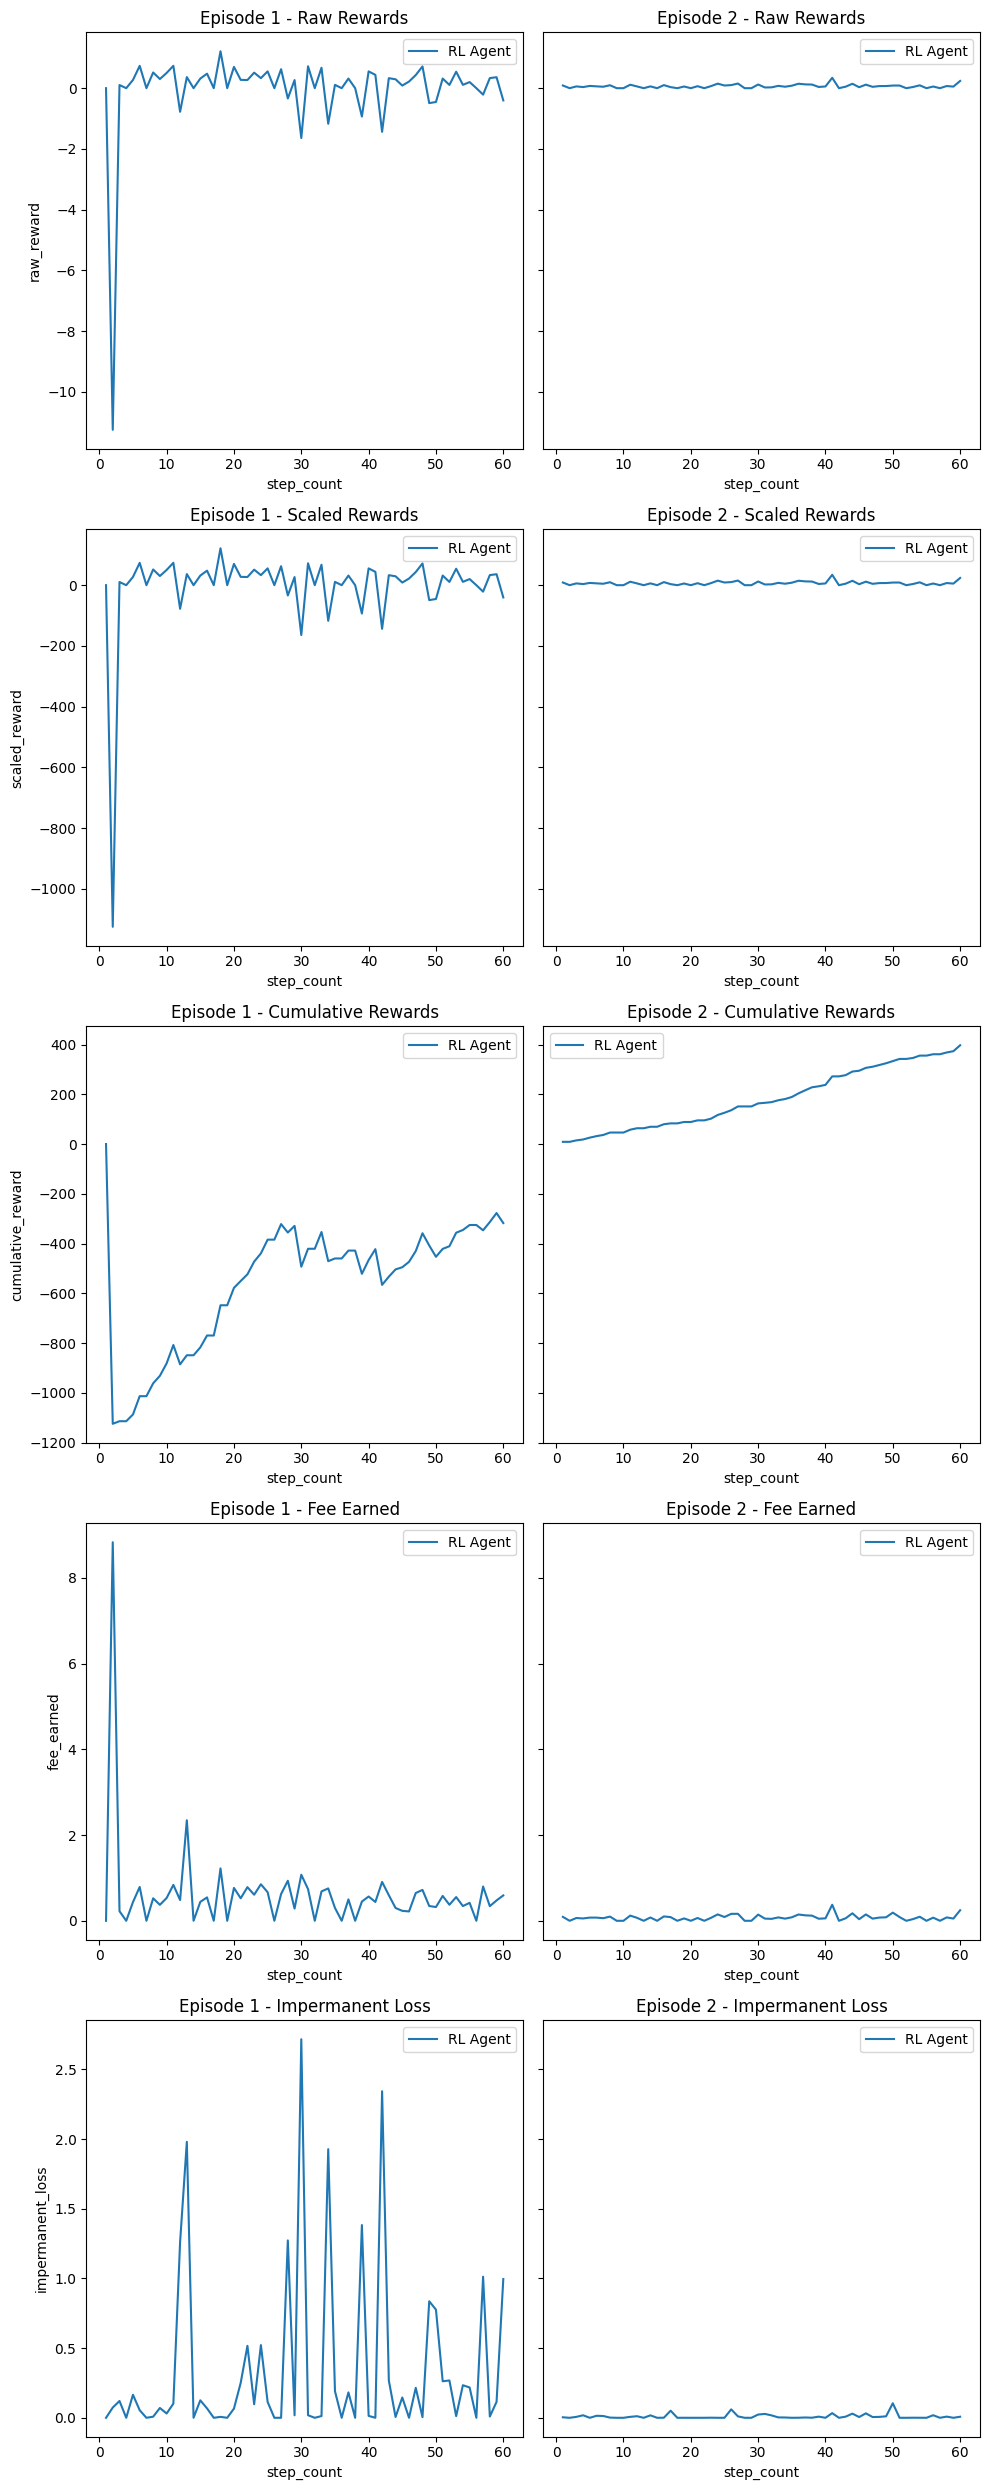

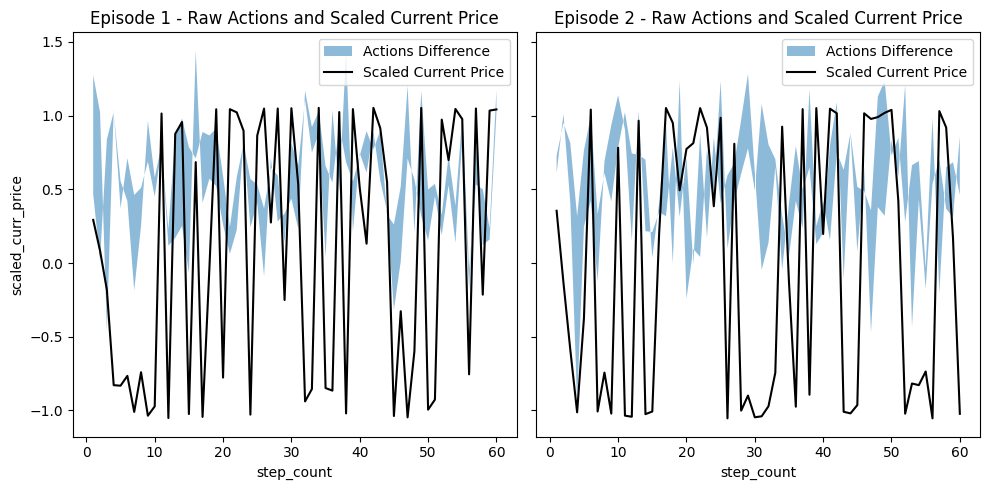

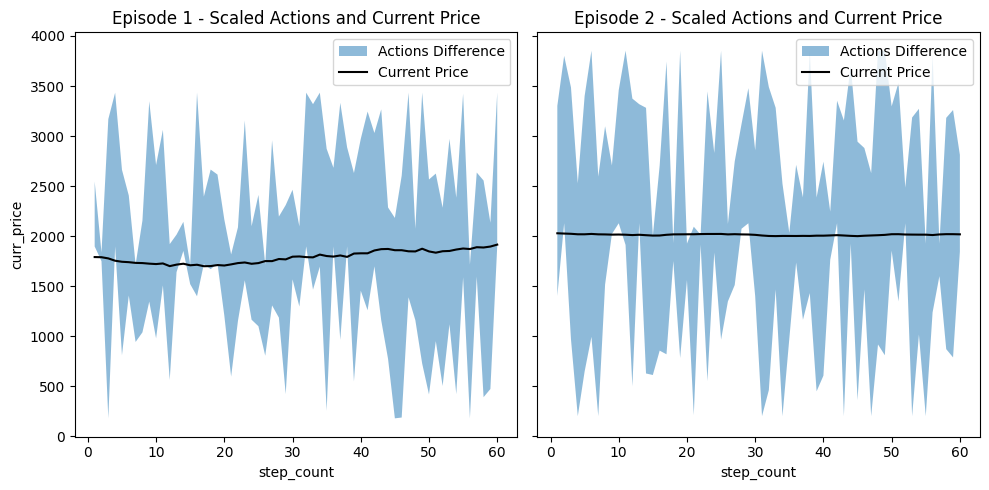

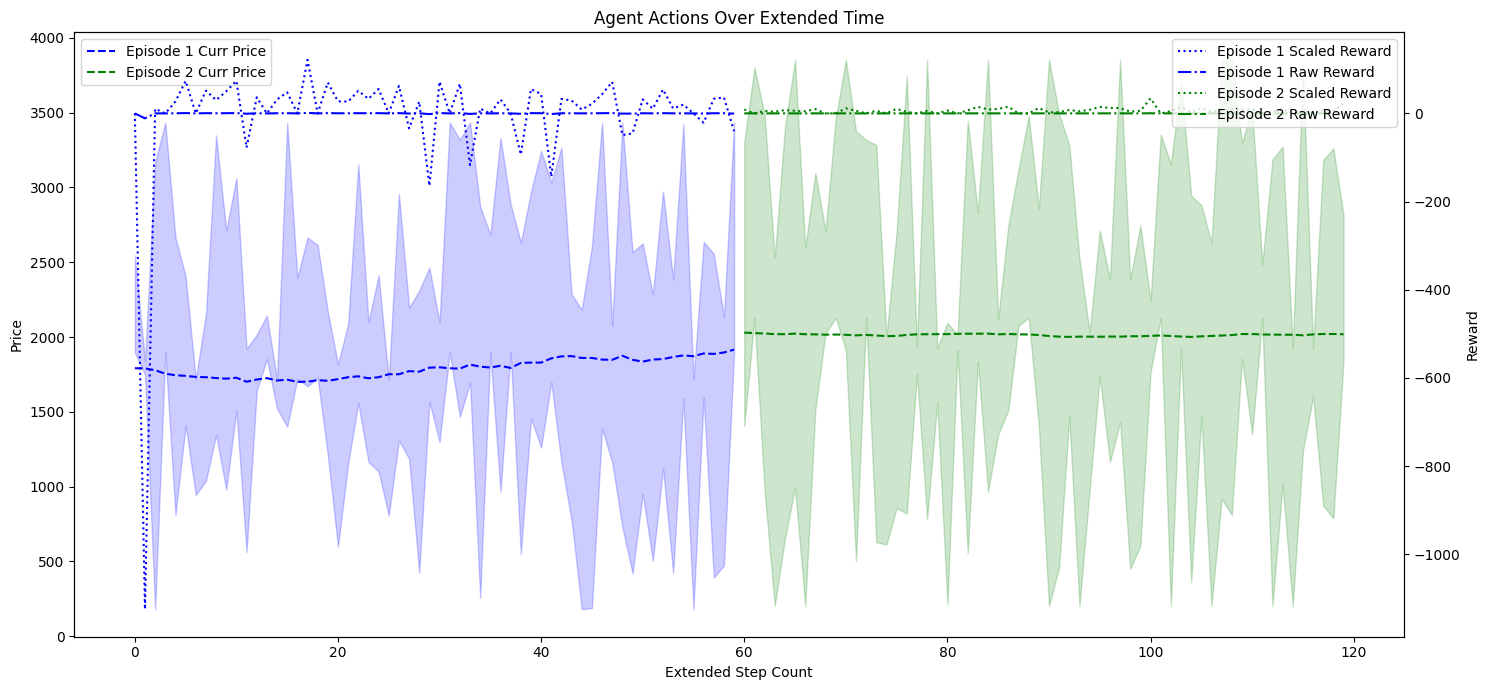

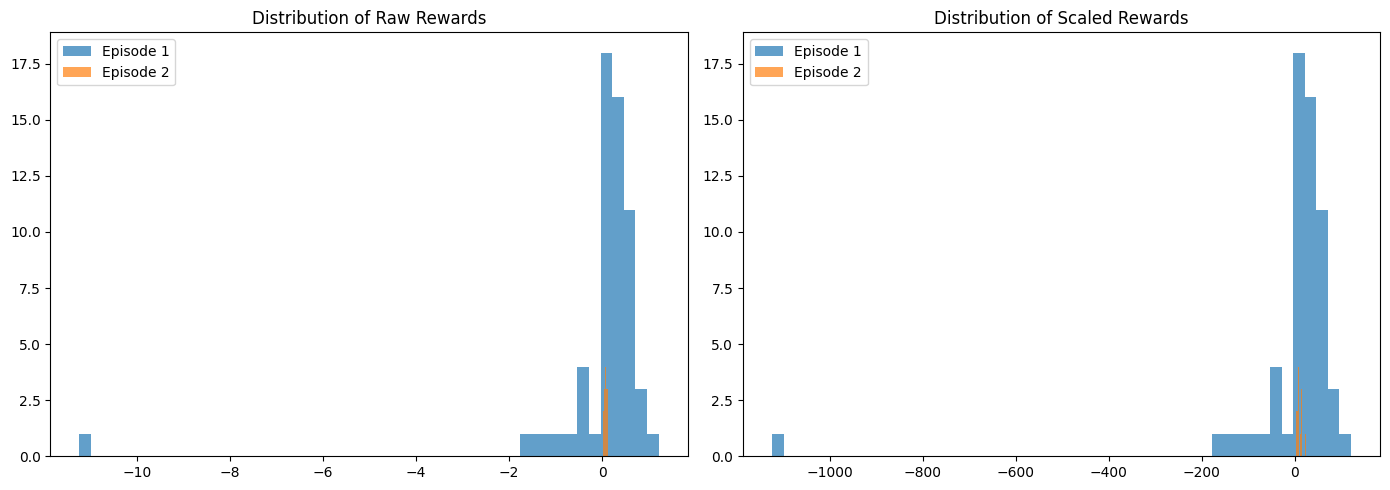

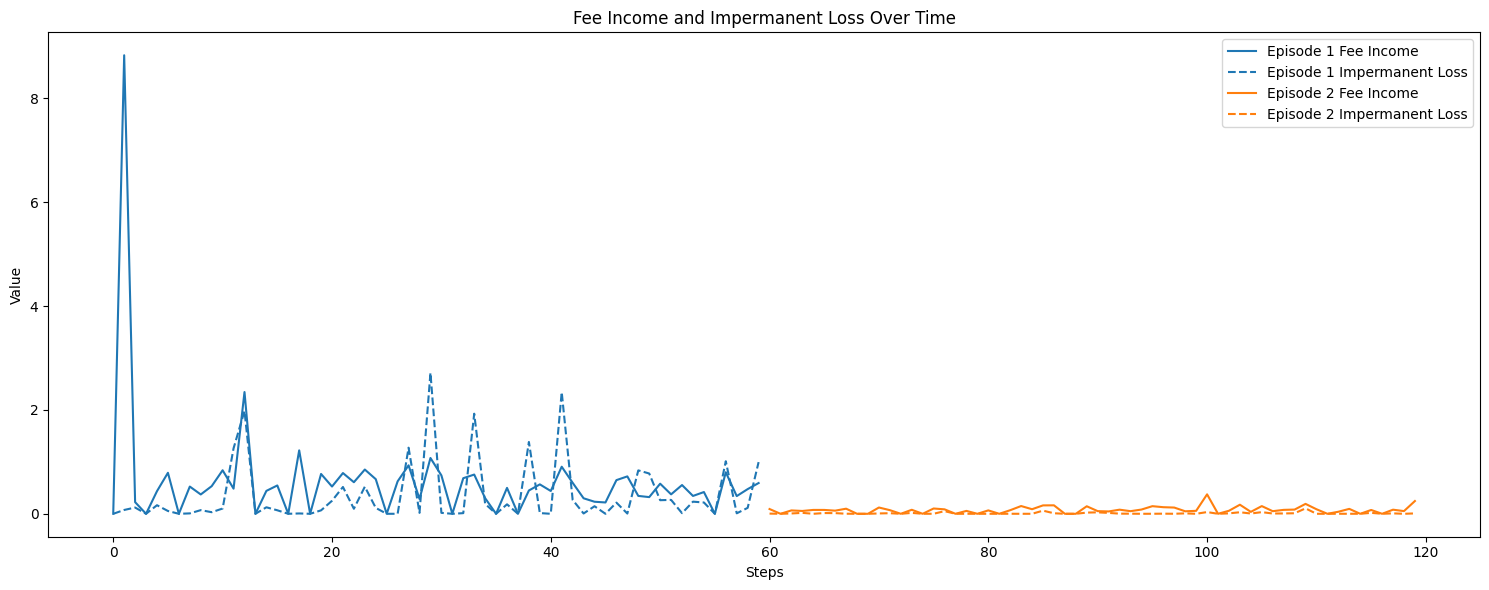

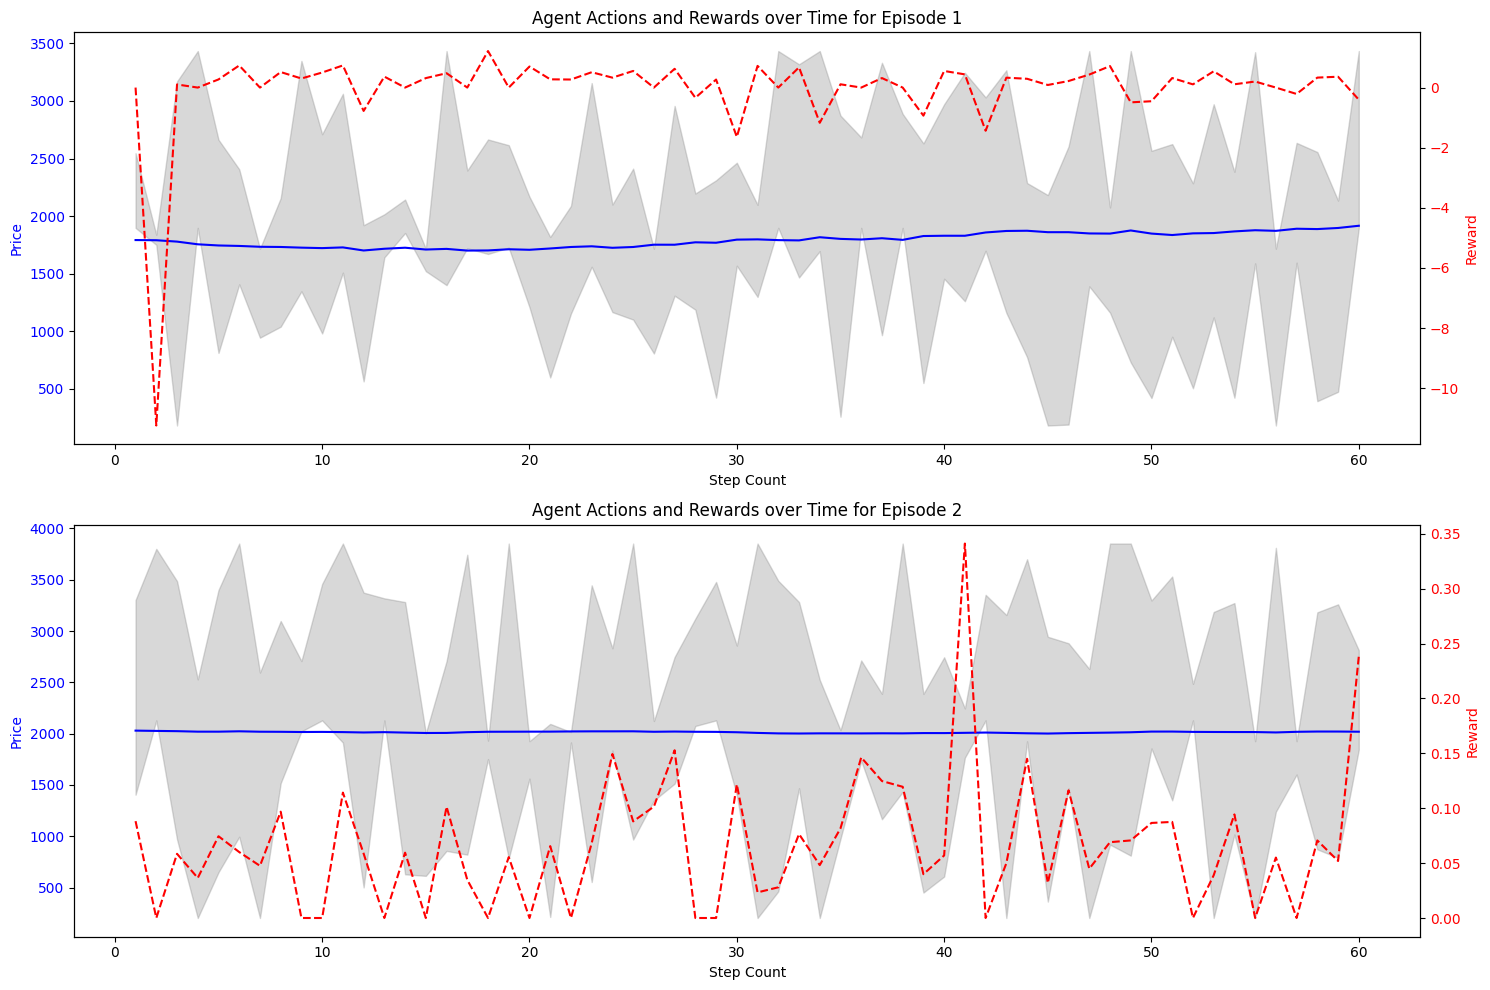

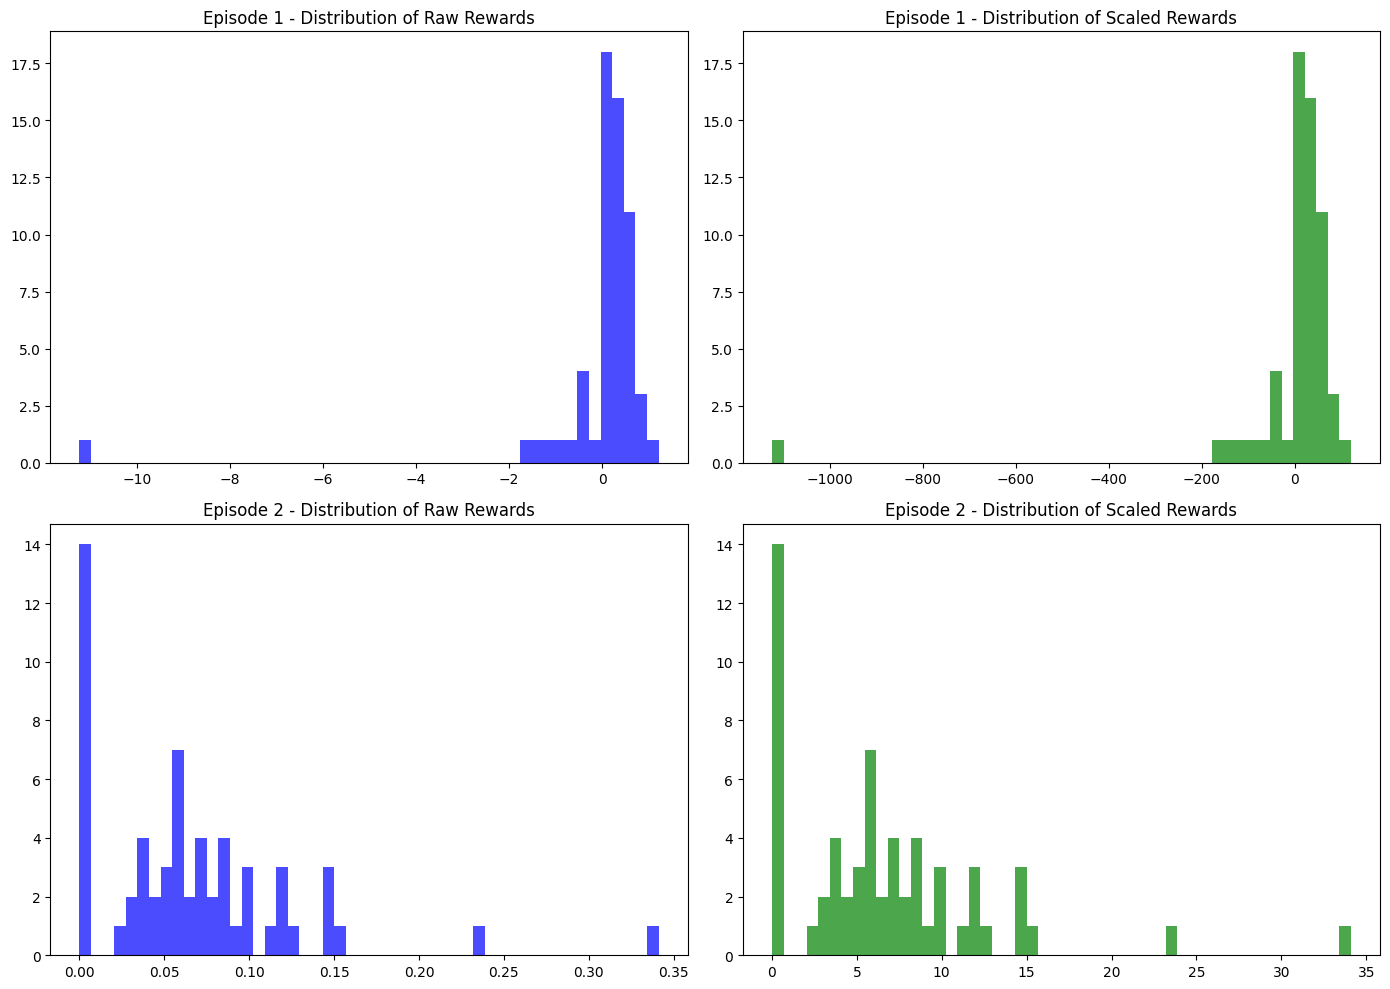

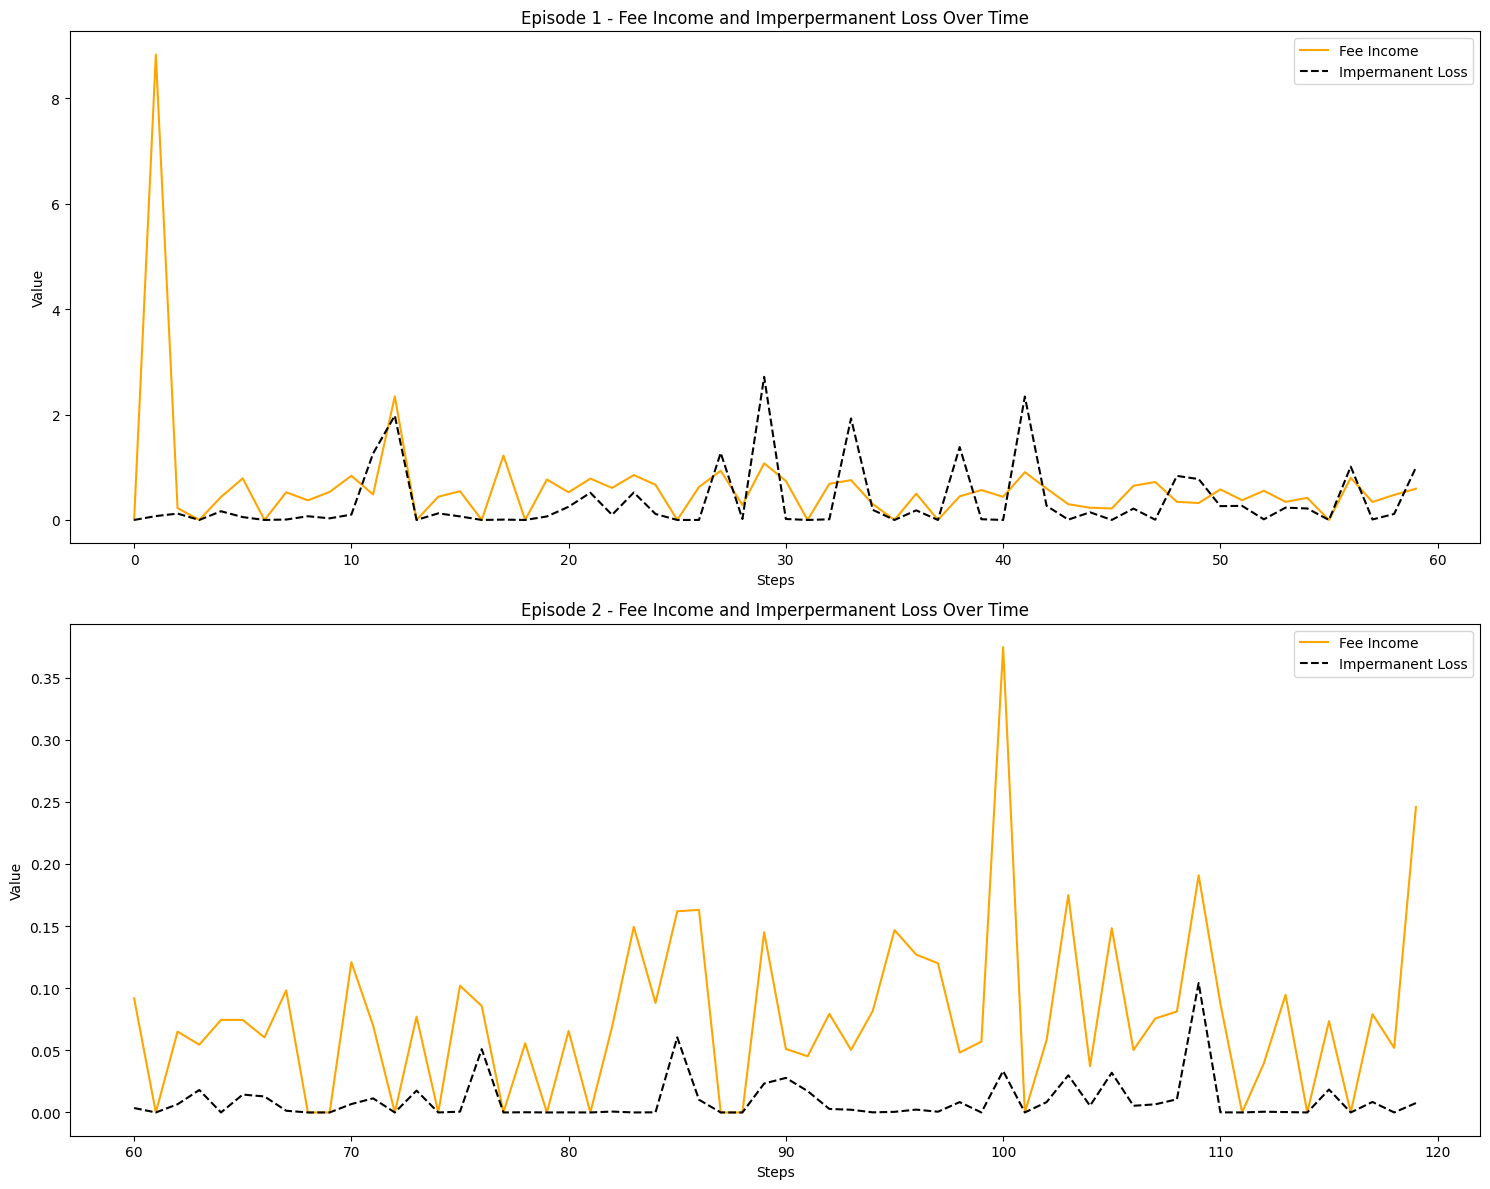

In [163]:
train_rewards_plot(data_df)
train_raw_actions_plot(data_df)
train_scaled_actions_plot(data_df)
train_combined_metrics_plot(data_df)
train_separate_episode_action_plot(data_df)

In [56]:
%reload_ext tensorboard

In [110]:
%load_ext tensorboard
%tensorboard --logdir ./model_storage

Launching TensorBoard...

## Save trained model weights

In [164]:
# Saving the actor model weights
actor_model_path = '/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/trained_model_multipool/actor'
agent.actor.save_weights(actor_model_path)

# Saving the critic model weights
critic_model_path = '/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/trained_model_mutipool/critic'
agent.critic.save_weights(critic_model_path)

# Policy Evaluation 

## Eval Env

In [165]:
class DiscreteSimpleEnvEval(DiscreteSimpleEnv):
    def __init__(self, agent_budget_usd, percentage_range, seed=None):
        super().__init__(agent_budget_usd)
        self.percentage_range = percentage_range
        if seed is not None:
            np.random.seed(seed)
        self.cumulative_reward_rl_agent = 0
        self.cumulative_reward_baseline_agent = 0

    def _take_action(self, action):
        # Disable exploration noise
        self.exploration_std_dev = 0.0
        return super()._take_action(action)
    
    def step(self, raw_action_rl_agent):
        # The RL agent takes an action
        mint_tx_receipt_rl_agent, action_rl_agent = self._take_action(raw_action_rl_agent)
        raw_action_baseline_agent=self.baseline_agent_policy()
        # The baseline agent takes an action
        mint_tx_receipt_baseline_agent, action_baseline_agent = self._take_action_baseline(raw_action_baseline_agent)

        # Perform environment step
        print('Environment Step')
        self.engine.reset()
        self.engine.run()
        print()

        # Calculate rewards for both agents
        scaled_reward_rl_agent, raw_reward_rl_agent, fee_income_rl_agent, impermanent_loss_rl_agent = self._calculate_reward(action_rl_agent, mint_tx_receipt_rl_agent)
        scaled_reward_baseline_agent, raw_reward_baseline_agent, fee_income_baseline_agent, impermanent_loss_baseline_agent = self._calculate_reward(action_baseline_agent, mint_tx_receipt_baseline_agent)

        # Update cumulative rewards
        self.cumulative_reward_rl_agent += scaled_reward_rl_agent
        self.cumulative_reward_baseline_agent += scaled_reward_baseline_agent

        self.step_count+=1
        # Print rewards and cumulative rewards for both agents
        print(f"episode: {self.episode}, step_count: {self.step_count}")
        print(f"rl_agent_scaled_reward: {scaled_reward_rl_agent}, rl_agent_raw_reward: {raw_reward_rl_agent}, rl_agent_cumulative_reward: {self.cumulative_reward_rl_agent}")
        print(f"baseline_agent_scaled_reward: {scaled_reward_baseline_agent}, baseline_agent_raw_reward: {raw_reward_baseline_agent}, baseline_agent_cumulative_reward: {self.cumulative_reward_baseline_agent}")
        print(f"raw_pool_state: {self.pool.get_global_state()}")
        print(f"sclaed_pool_state: {self.state}")
        print()
      

        # Update the state and check if the episode is done
        self.state = self.get_obs_space()
        self.done = self._is_done()
        eval_data_log.append((self.episode, self.step_count, self.pool.get_global_state(), raw_action_rl_agent,action_rl_agent,raw_action_baseline_agent,action_baseline_agent, self.state, raw_reward_rl_agent, raw_reward_baseline_agent,scaled_reward_rl_agent,scaled_reward_baseline_agent, self.cumulative_reward_rl_agent, self.cumulative_reward_baseline_agent, fee_income_rl_agent, impermanent_loss_rl_agent,fee_income_baseline_agent,impermanent_loss_baseline_agent))
        # Return the necessary information
        return self.state, raw_reward_rl_agent, self.done, {}
    
    def _take_action_baseline(self, action_dict):
        
        print('Baseline Agent Action')
        print(f"action: {action_dict}")

        tick_lower=price_to_valid_tick(action_dict['price_lower'])
        tick_upper=price_to_valid_tick(action_dict['price_upper'])
        amount=self.agent_budget_usd

        mint_tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        return mint_tx_receipt,action_dict
    
    
    def baseline_agent_policy(self):
        global_state = self.pool.get_global_state()
        raw_curr_price = global_state['curr_price']
        
        # Calculate the price range based on the raw current price
        lower_price = raw_curr_price * (1 - self.percentage_range)
        upper_price = raw_curr_price * (1 + self.percentage_range)

        action_baseline={
            'price_lower':lower_price,
            'price_upper':upper_price
        }
        
        return action_baseline


## Evaluation

### DDPG Eval

In [157]:
class DDGPEval(DDPG):
    def choose_action(self, state):
        # Disable exploration noise
        action = super().choose_action(state)
        return action

eval_data_log=[]
eval_env = DiscreteSimpleEnvEval(agent_budget_usd=1000,percentage_range=0.30, seed=42)
eval_agent = DDGPEval(alpha=0.001, beta=0.002, input_dims=input_dims, tau=0.2, env=eval_env,
                      n_actions=n_actions,batch_size=5)

eval_agent.actor.load_weights(actor_model_path)
eval_agent.critic.load_weights(critic_model_path)

In [ ]:
n_evaluation_episodes = 2
max_steps_per_episode = 5

cumulative_rewards = []
actions_taken = []
states_visited = []

for episode in range(n_evaluation_episodes):
    state = eval_env.reset()
    episode_reward = 0
    
    for step in range(max_steps_per_episode):
        action = eval_agent.choose_action(state)
        next_state, reward, done, _ = eval_env.step(action)
        
        episode_reward += reward
        actions_taken.append(action)
        states_visited.append(state)
        
        state = next_state
        if done:
            break
    
    cumulative_rewards.append(episode_reward)
    print(f"Episode {episode+1}/{n_evaluation_episodes}, Reward: {episode_reward}")

# Analysis and Visualization
average_reward = np.mean(cumulative_rewards)
print(f"Average Reward: {average_reward}")

### PPO Eval

In [166]:
class PPOEval(PPO):
    def choose_action(self, state):
        # Disable exploration noise
        action = super().choose_action(state)
        return action

eval_data_log=[]
eval_env = DiscreteSimpleEnvEval(agent_budget_usd=10000,percentage_range=0.30, seed=42)
eval_agent = PPOEval(eval_env, n_actions, observation_dims,buffer_size=5)

eval_agent.actor.load_weights(actor_model_path)
eval_agent.critic.load_weights(critic_model_path)

In [167]:
n_evaluation_episodes = 2
max_steps_per_episode = 10

cumulative_rewards = []
actions_taken = []
states_visited = []

for episode in range(n_evaluation_episodes):
    state = eval_env.reset()
    episode_reward = 0
    
    for step in range(max_steps_per_episode):
        action,_ = eval_agent.choose_action(state)
        next_state, reward, done, _ = eval_env.step(action)
        
        episode_reward += reward
        actions_taken.append(action)
        states_visited.append(state)
        
        state = next_state
        if done:
            break
    
    cumulative_rewards.append(episode_reward)
    print(f"Episode {episode+1}/{n_evaluation_episodes}, Reward: {episode_reward}")

# Analysis and Visualization
average_reward = np.mean(cumulative_rewards)
print(f"Average Reward: {average_reward}")

Pool selcted for this episode: ETH_DAI_3000
mnemonic: 'chair artwork blood capable soon mammal prefer awkward radio parrot another because'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x07ff3401ded0e484e69c39A3Fd7156632964E9AB'), ('value', 1000000000000000019884624838656)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x07ff3401ded0e484e69c39A3Fd7156632964E9AB'), ('value', 110000000000000000498458871988224)])]}
mnemonic: 'oval figure vacant empty bargain knee reduce mushroom exile guitar trial owner'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x73e5b74783c004761d428AC1C9C19E223d04c942'), ('value', 4999999999999999727876154935214080)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x73e5b74

## Eval Visualization

In [168]:
df_eval_data = []

for entry in eval_data_log:
    (episode, step_count, global_state, raw_action_rl_agent, action_rl_agent, 
     raw_action_baseline_agent, action_baseline_agent, state, 
     raw_reward_rl_agent, raw_reward_baseline_agent,scaled_reward_rl_agent,scaled_reward_baseline_agent, cumulative_reward_rl_agent, 
     cumulative_reward_baseline_agent, fee_income_rl_agent, impermanent_loss_rl_agent, 
     fee_income_baseline_agent, impermanent_loss_baseline_agent) = entry
    
    # Extract raw_action values for RL agent
    raw_action_rl_agent_0 = float(raw_action_rl_agent[0][0].numpy())
    raw_action_rl_agent_1 = float(raw_action_rl_agent[0][1].numpy())

    scaled_action_rl_agent_0 = action_rl_agent['price_lower']
    scaled_action_rl_agent_1 = action_rl_agent['price_upper']
    
    # Extract raw_action values for baseline agent
    raw_action_baseline_agent_0 = raw_action_baseline_agent['price_lower']
    raw_action_baseline_agent_1 = raw_action_baseline_agent['price_upper']
    
    # Combine all data into a single dictionary
    data = {
        'episode': episode,
        'step_count': step_count,
        'raw_reward_rl_agent': raw_reward_rl_agent,
        'scaled_reward_rl_agent':scaled_reward_rl_agent,
        'cumulative_reward_rl_agent': cumulative_reward_rl_agent,
        'scaled_action_rl_agent_0':scaled_action_rl_agent_0,
        'scaled_action_rl_agent_1':scaled_action_rl_agent_1,
        'fee_income_rl_agent': fee_income_rl_agent,
        'impermanent_loss_rl_agent': impermanent_loss_rl_agent,
        'raw_reward_baseline_agent': raw_reward_baseline_agent,
        'scaled_reward_baseline_agent':scaled_reward_baseline_agent,
        'cumulative_reward_baseline_agent': cumulative_reward_baseline_agent,
        'raw_action_baseline_agent_0': raw_action_baseline_agent_0,
        'raw_action_baseline_agent_1': raw_action_baseline_agent_1,
        'fee_income_baseline_agent': fee_income_baseline_agent,
        'impermanent_loss_baseline_agent': impermanent_loss_baseline_agent,
        'raw_action_rl_agent_0': raw_action_rl_agent_0,
        'raw_action_rl_agent_1': raw_action_rl_agent_1,

    }
    
    # Add action, global_state, and state data
    
    data.update(global_state)
    data.update(state)
    
    df_eval_data.append(data)

eval_data_df = pd.DataFrame(df_eval_data)
eval_data_df.to_csv('model_outdir_csv/rl_agent_eval_data.csv', index=False)
eval_data_df.head()

,episode,step_count,raw_reward_rl_agent,scaled_reward_rl_agent,cumulative_reward_rl_agent,scaled_action_rl_agent_0,scaled_action_rl_agent_1,fee_income_rl_agent,impermanent_loss_rl_agent,raw_reward_baseline_agent,...,feeGrowthGlobal0X128,feeGrowthGlobal1X128,liquidity_raw,blockTimestamp,tickCumulative,secondsPerLiquidityCumulativeX128,scaled_curr_price,scaled_liquidity,scaled_feeGrowthGlobal0x128,scaled_feeGrowthGlobal1x128
0,1,1,0.194756,19.475633,19.475633,938.216334,2468.120348,0.206635,0.011878,0.288927,...,7327230079592116795570850800215400,13276956221799475233935387250832447396,852224904705007217840000,2099326839,28020494319035,95257062650133381654506,0.321915,-0.012028,-0.993966,-0.993872
1,1,2,0.113565,11.356471,30.832104,309.337874,1721.115247,0.155287,0.041722,0.255484,...,7351048797582078600178817308409183,13368427012634315269748092072709542571,856138980937976863540000,2099586086,28039085094616,95360334086066705689007,0.133666,0.039562,-0.304368,-0.295397
2,1,3,0.559790,55.978952,86.811056,1129.104898,1617.703631,0.564538,0.004748,0.336541,...,7400808579105954449827682484951752,13422754830367029012504709675390579167,857085336560638731440000,2099845338,28057682450672,95462927104675249032327,0.024196,0.045622,-0.058385,-0.122550
3,1,4,0.231421,23.142079,109.953135,770.013384,2250.595788,0.269915,0.038494,0.381321,...,7441554339078293990036484186965856,13525671085038090023832192667510145438,856064272076397114940000,2100104592,28076279691143,95565477560738085743651,0.267873,-0.098159,-0.059811,0.084130
4,1,5,0.000000,0.000000,109.953135,1363.961245,1786.417867,0.000000,0.000000,0.227759,...,7461482215257963746498999194321902,13606834200770499996029720013767594985,858697440746472329440000,2100363842,28094891161922,95668479302367687395567,0.724125,0.678501,-0.307172,-0.145779


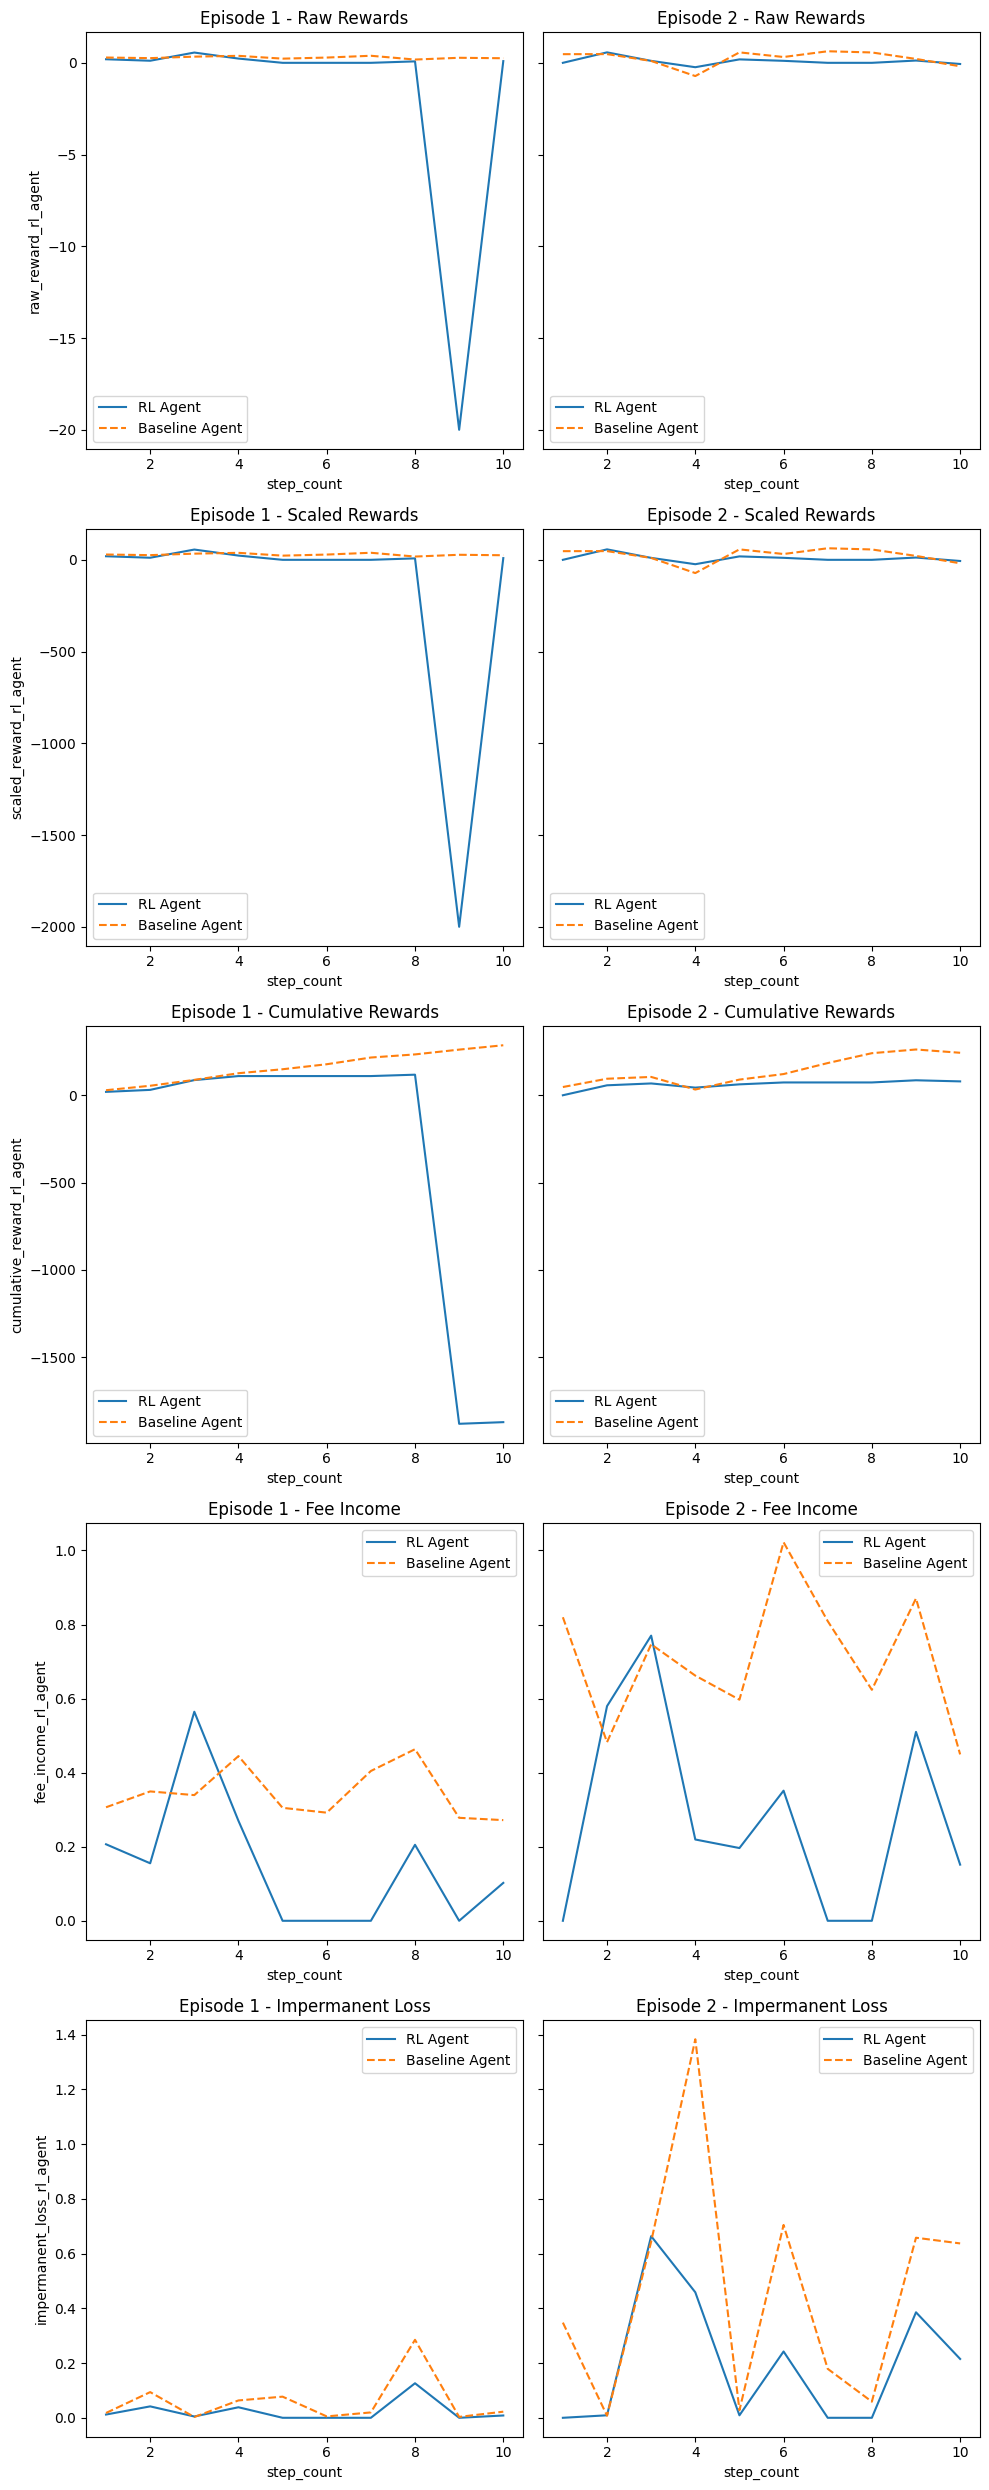

In [169]:
eval_rewards_plot(eval_data_df)